In [3]:
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import convolve
import sklearn
from sklearn.metrics import mean_squared_error as mse
import skimage as ski
from skimage.util import random_noise
from PIL import Image as im

In [4]:
data = loadmat("./output/shapes_poly4_star8_ellipse_dims_rota_trx_try_scale.mat")
print(len(data['images']),len(data['images'][0]))

3 625


0.0


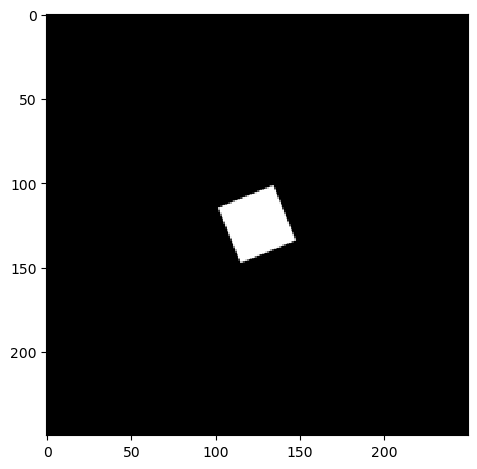

In [5]:
u = data['images'][0][438].astype(np.uint8)
u = ski.util.img_as_float(u)
ski.io.imshow(u)
print(np.min(u))

0.0


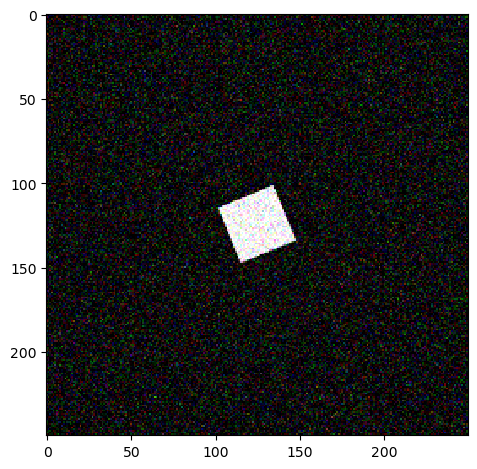

In [6]:
sigma = 0.155
noised_u = random_noise(u, var=sigma**2)
ski.io.imshow(noised_u)
print(np.min(noised_u))

In [99]:
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	"""
	Anisotropic diffusion.

	Usage:
	imgout = anisodiff(im, niter, kappa, gamma, option)

	Arguments:
	        img    - input image
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the image will be plotted on every iteration

	Returns:
	        imgout   - diffused image.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x and y axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.

	Reference: 
	P. Perona and J. Malik. 
	Scale-space and edge detection using ansotropic diffusion.
	IEEE Transactions on Pattern Analysis and Machine Intelligence, 
	12(7):629-639, July 1990.

	Original MATLAB code by Peter Kovesi  
	School of Computer Science & Software Engineering
	The University of Western Australia
	pk @ csse uwa edu au
	<http://www.csse.uwa.edu.au>

	Translated to Python and optimised by Alistair Muldal
	Department of Pharmacology
	University of Oxford
	<alistair.muldal@pharm.ox.ac.uk>

	June 2000  original version.       
	March 2002 corrected diffusion eqn No 2.
	July 2012 translated to Python
	"""

	# ...you could always diffuse each color channel independently if you
	# really want
	if img.ndim == 3:
		print("Only grayscale images allowed, converting to 2D matrix")
		img = ski.color.rgb2gray(img)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=ndimage.gaussian_filter(deltaS,sigma)
			deltaEf=ndimage.gaussian_filter(deltaE,sigma)
		else: 
			deltaSf=deltaS
			deltaEf=deltaE
			
		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout

/root/miniconda3/envs/generator/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


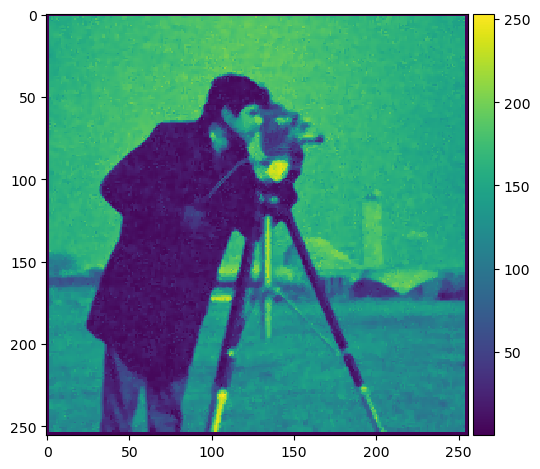

In [100]:
img = ski.io.imread('/root/code/cameraman.jpg')
img = img.astype(float)

processed = anisodiff(img,niter=10,kappa=10,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False)
ski.io.imshow(processed)

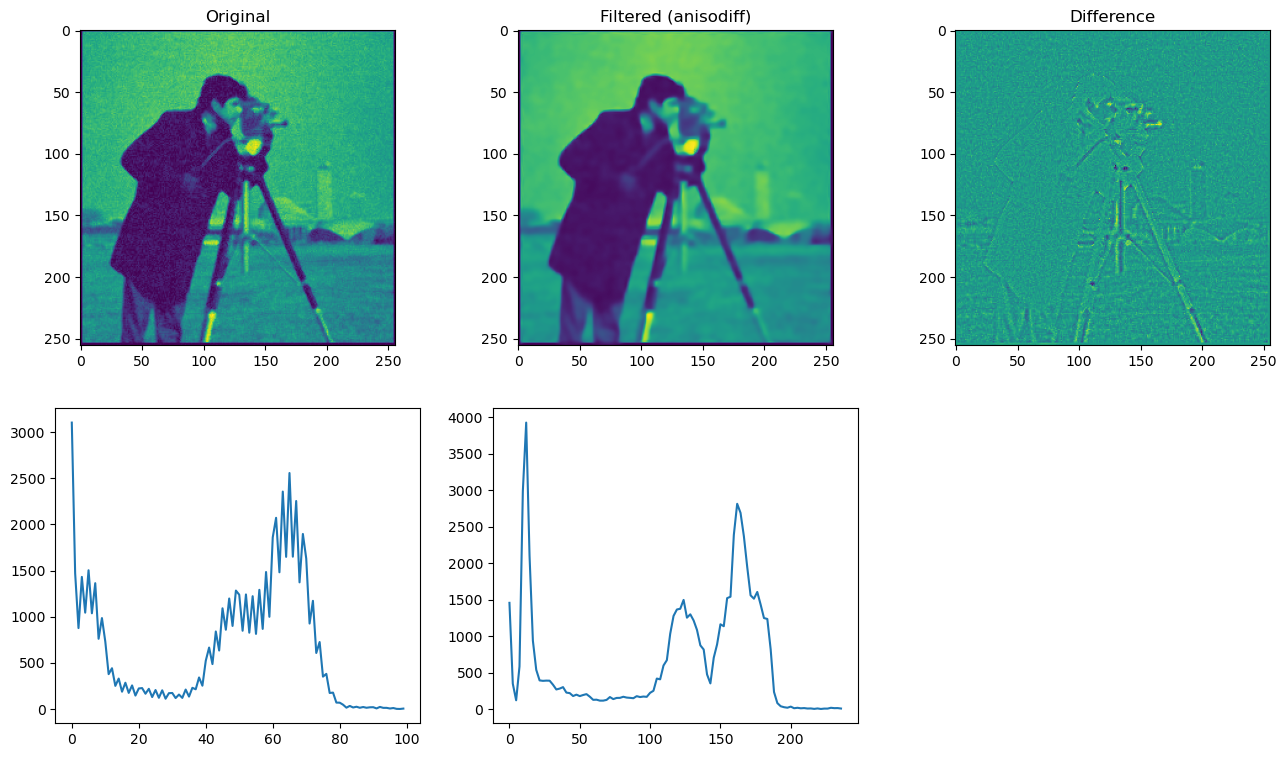

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
fimg=anisodiff(img,30,10,0.075,(1,1),2.5,1)
plt.subplot(2,3,1)
plt.imshow(img)
plt.title('Original')
plt.subplot(2,3,2)
plt.imshow(fimg)
#plt.imshow(fimg)
plt.title('Filtered (anisodiff)')
plt.subplot(2,3,3)
plt.imshow(fimg-img)
plt.title('Difference')
plt.subplot(2,3,4)
h=np.histogram(img,100)
plt.plot(h[0])

plt.subplot(2,3,5)
h,ax=np.histogram(fimg,100)

plt.plot(ax[0:(np.size(h))],h)

In [7]:
from tqdm import tqdm
from numba import jit, prange
#@title Utility functions for curvature flow

@jit(nopython=True, boundscheck=False, cache=True)
def pointwiseLazyRHS(u, threshold):
    ''' u.shape = (3,3), threshold = float
    returns |Du| k(u)^1/3 = (u_y^2 u_xx - 2u_x u_y u_xy + u_x^2 u_yy) ^ (1/3) 
    '''
    u_x = .5*(u[2, 1] - u[0, 1])
    u_y = .5*(u[1, 2] - u[1, 0])
    u_xx = u[2,1] - 2*u[1,1] + u[0, 1]
    u_yy = u[1,2] - 2*u[1,1] + u[1, 0]
    u_xy = .25*(u[2,2] - u[2,0] - u[0,2] + u[0,0])

    return np.cbrt(u_y**2*u_xx - 2*u_x*u_y*u_xy + u_x**2*u_yy)
    

@jit(nopython=True, boundscheck=False, cache=True, parallel=True)
def doLazystep(un, unp1, dt):
    threshold = 1e-10
    for i in prange(un.shape[0]):
        im, ip = int(max(i - 1, 0)), int(min(i + 1, un.shape[0] - 1))
        buf = np.empty((3, 3), dtype='float32')

        j = 0
        buf[0, 0], buf[0, 1], buf[0, 2] = un[im, 0], un[im, 0], un[im, 1]
        buf[1, 0], buf[1, 1], buf[1, 2] = un[i, 0], un[i, 0], un[i, 1]
        buf[2, 0], buf[2, 1], buf[2, 2] = un[ip, 0], un[ip, 0], un[ip, 1]
        unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)

        j += 1
        while j < un.shape[1] - 1:
            buf[:, :2] = buf[:, 1:]
            buf[0, 2], buf[1, 2], buf[2, 2] = un[im, j + 1], un[i, j + 1], un[ip, j + 1]
            unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)
            j += 1

        buf[:, :2] = buf[:, 1:]  # buf[:, 2] stays the same
        unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)


def computeFlow(u, dx, dt, Tmax, frames):
    # step = doLazystep
    U = [u[None].copy()]
    u, v = u.copy(), u.copy()
    frame, frames = 1, np.linspace(0, Tmax, frames)

    # Very lazy hack to get minimal arange with T[-1]>=Tmax
    T = np.arange(0,Tmax+2*dt,dt)[1:]
    while T[-2]>=Tmax:
        T = T[:-1]

    for t in tqdm(T):
        doLazystep(u, v, dt / dx**(4 / 3))
        if t >= frames[frame]:
            U.append(v[None].copy())
            frame += 1
        u, v = v, u
    return u, frames, np.concatenate(U, axis=0)


def curvature_pde(X, u):
    # returns u_t^3 - |Du|^3 k(u) = u_t^3 - (u_y^2 u_xx - 2u_x u_y u_xy + u_x^2 u_yy)
    if X.shape[0] == 0:
        return np.array(0.0)
    U = u(X)
    dU = np.zeros_like(X)
    dU[:, 0] = np.gradient(U[:, 0], X[:, 0])  # first derivative wrt t
    dU[:, 1] = np.gradient(U[:, 0], X[:, 1])  # first derivative wrt x
    dU[:, 2] = np.gradient(U[:, 0], X[:, 2])  # first derivative wrt y
    U_t, U_x, U_y = dU[:, [0]], dU[:, [1]], dU[:, [2]]
    dU_x = np.zeros_like(X)
    dU_x[:, 1] = np.gradient(U_x[:, 0], X[:, 1])  # second derivative wrt x
    dU_x[:, 2] = np.gradient(U_x[:, 0], X[:, 2])  # second derivative wrt y
    U_xx, U_xy = dU_x[:, [1]], np.gradient(U_x[:, 0], X[:, 2])[:, [2]]
    U_yy = np.gradient(U_y[:, 0], X[:, 2])[:, [2]]  # second derivative wrt y
    return U_t**3 - (U_y**2 * U_xx - 2 * U_x * U_y * U_xy + U_x**2 * U_yy)
    # return U_t - np.power(U_y**2 * U_xx - 2 * U_x * U_y * U_xy + U_x**2 * U_yy, 1/3)


100%|██████████| 20000/20000 [00:15<00:00, 1284.82it/s]


(250, 250, 3)


100%|██████████| 20000/20000 [00:19<00:00, 1030.07it/s]


(250, 250, 3)


100%|██████████| 20000/20000 [00:19<00:00, 1007.43it/s]


(250, 250, 3)
3


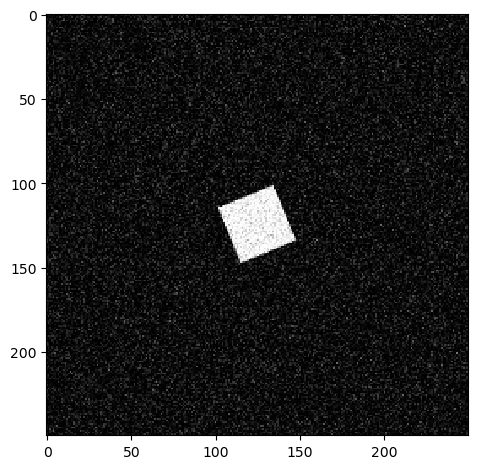

In [8]:
grayscale = ski.color.rgb2gray(noised_u)
stacked_img = np.stack((grayscale,)*3, axis=-1)
ski.io.imshow(stacked_img)
dt = 1e-3
ops = {'dx':100/min(stacked_img.shape[:-1]), 'Tmax':20, 'frames':12}
carry = []
for i in range(stacked_img.shape[-1]):
    # print(noised_u.shape)
    # print(noised_u[...,i].shape)
    out, t, U = computeFlow(stacked_img[...,i], dt=dt, **ops)
    print(u.shape)
    # carry = [carry, out]
    out -= np.min(out)
    out /= np.max(out)
    carry.append(out)
print(len(carry))

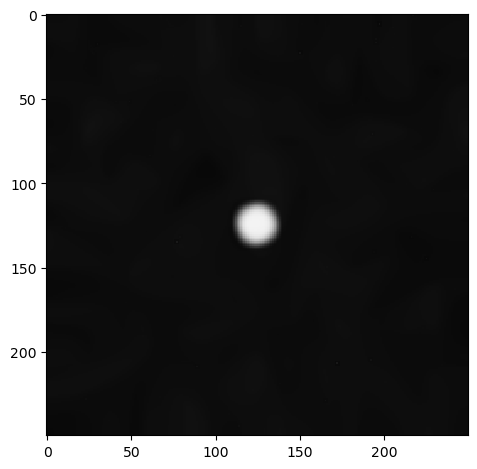

In [9]:
ski.io.imshow(U[4,...])

In [7]:
from create import makeDataset
import numpy as np
import skimage as ski
from skimage.color import rgba2rgb,rgb2gray
import time

start = time.time()
test = makeDataset(250,100,3,8,True)
end = time.time()
print("100 images created in ", end-start)
# temp = ski.util.img_as_float(test[0,...])
# print(np.min(temp),np.max(temp),temp.shape)
# ski.io.imshow(temp)


-----new image----
Total objects:  4
Added Polygon
Added Rect
Added Polygon
Added Rect
-----new image----
Total objects:  6
Added Rect
Added Circle
Added Circle
Added Star
Added Rect
Added Polygon
-----new image----
Total objects:  7
Added Polygon
Added Star
Added Rect
Added Rect
Added Rect
Added Rect
Added Circle
-----new image----
Total objects:  5
Added Rect
Added Circle
Added Rect
Added Star
Added Rect
-----new image----
Total objects:  7
Added Rect
Added Polygon
Added Rect
Added Polygon
Added Rect
Added Circle
Added Star
-----new image----
Total objects:  7
Added Polygon
Added Polygon
Added Star
Added Rect
Added Rect
Added Star
Added Rect
-----new image----
Total objects:  6
Added Circle
Added Star
Added Circle
Added Circle
Added Circle
Added Star
-----new image----
Total objects:  4
Added Star
Added Polygon
Added Star
Added Rect
-----new image----
Total objects:  7
Added Rect
Added Polygon
Added Star
Added Polygon
Added Polygon
Added Polygon
Added Star
-----new image----
Total ob

In [34]:
from create import makeDataset
import numpy as np
import skimage as ski
from skimage.color import rgba2rgb,rgb2gray
import time
from curvature_flow import computeFlow as flow

num_images = 50
size = 250
frames = 5
dt = 1e-3
ops = {'dx':100/size, 'Tmax':20, 'frames':frames}

start = time.time()
test = makeDataset(size,num_images,3,8,False)
end = time.time()
print(size," images created in ", end-start)

processed = np.zeros((num_images,size,size),np.float16)
frames = np.zeros((num_images,frames,size,size), np.float16)
start = time.time()
for i in range(test.shape[0]):
    processed[i,...], _, frames[i,...]= flow(test[i,...], dt=dt, **ops)
end = time.time()
print(size," images processed using fancy flat curvature flow.")

# temp = ski.util.img_as_float(test[0,...])
# print(np.min(temp),np.max(temp),temp.shape)
# ski.io.imshow(temp)


-----new image----
Total objects:  5
Added Rect
Added Circle
Added Star
Added Star
Added Rect
-----new image----
Total objects:  5
Added Rect
Added Rect
Added Polygon
Added Rect
Added Rect
-----new image----
Total objects:  4
Added Polygon
Added Polygon
Added Polygon
Added Rect
-----new image----
Total objects:  4
Added Rect
Added Star
Added Circle
Added Circle
-----new image----
Total objects:  3
Added Polygon
Added Rect
Added Star
-----new image----
Total objects:  3
Added Polygon
Added Rect
Added Rect
-----new image----
Total objects:  4
Added Star
Added Rect
Added Polygon
Added Rect
-----new image----
Total objects:  3
Added Polygon
Added Polygon
Added Polygon
-----new image----
Total objects:  4
Added Star
Added Star
Added Polygon
Added Circle
-----new image----
Total objects:  6
Added Rect
Added Rect
Added Rect
Added Circle
Added Star
Added Polygon
-----new image----
Total objects:  7
Added Star
Added Star
Added Polygon
Added Rect
Added Circle
Added Star
Added Polygon
-----new im

100%|██████████| 20000/20000 [00:14<00:00, 1344.71it/s]

250  images processed using fancy flat curvature flow.


In [61]:
# ski.io.imshow(frames[49,4,...])
# print(frames[49,4,...].shape)
for i in range(frames.shape[0]):
    for j in range(frames.shape[1]):
        out = frames[i,j,...]
        out -= np.min(out)
        out /= np.max(out)
        out = np.min(test[i]) + (np.max(test[i])-np.min(test[i]))*out
        frames[i,j,...] = out
np.save("50_5frames_250flat", frames)

51 :  65 255


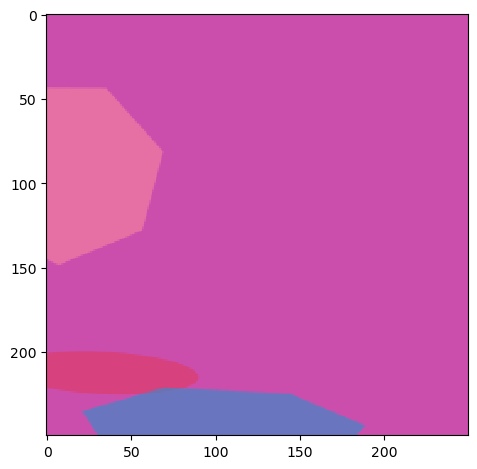

In [8]:
i = np.random.randint(0,99)
print(i, ": ", np.min(test[i,...]), np.max(test[i,...]))
ski.io.imshow(test[i,...])

(250, 250, 3) 3


100%|██████████| 20000/20000 [02:18<00:00, 144.69it/s]

fancy:  138.24167895317078


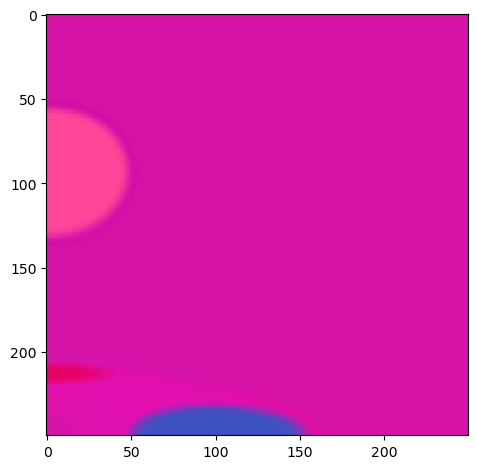

In [17]:
from curvature_flow import computeFlow as flow

bleh = ski.color.rgba2rgb(test[i,...])
print(bleh.shape, bleh.ndim)

dt = 1e-3
ops = {'dx':100/min(bleh.shape[:-1]), 'Tmax':20, 'frames':12}
start = time.time()
u, t, U = flow(bleh, dt=dt, **ops)
end = time.time()
print("fancy: ", end-start)
u -= np.min(u)
u /= np.max(u)
ski.io.imshow(u)

100%|██████████| 20000/20000 [02:10<00:00, 153.56it/s]


lazy:  130.25437116622925


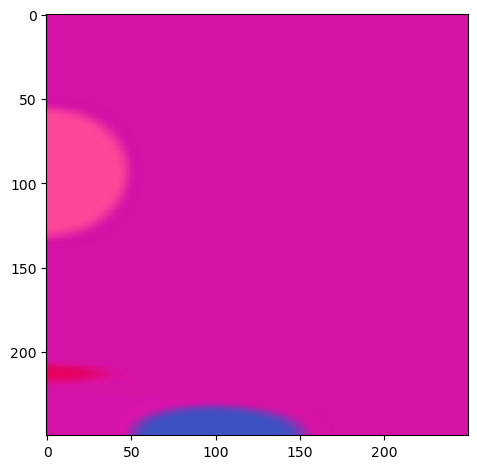

In [18]:
start = time.time()
u, t, U = flow(bleh, dt=dt, version='lazy',**ops)
end = time.time()
print("lazy: ", end-start)
u -= np.min(u)
u /= np.max(u)
ski.io.imshow(u)

(250, 250) 2


100%|██████████| 20000/20000 [00:09<00:00, 2156.81it/s]

flat fancy:  9.280319213867188


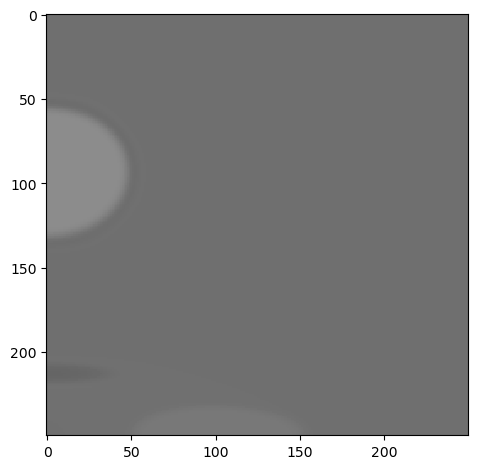

In [31]:
flat = ski.color.rgb2gray(bleh)
print(flat.shape, flat.ndim)

dt = 1e-3
ops = {'dx':100/min(flat.shape[:-1]), 'Tmax':20, 'frames':12}
start = time.time()
u, t, U = flow(flat, dt=dt, **ops)
end = time.time()
print("flat fancy: ", end-start)
# u -= np.min(u)
# u /= np.max(u)
ski.io.imshow(u)